# Feature Selection using Wrappers

---
`scikit learn` does not provide a comprehenisive implementation of Wrapper feature selection so we use `MLxtend`.  
http://rasbt.github.io/mlxtend/
So you will probably need to install some libraries:  
`pip install mlxtend`  
`pip install joblib`

In [83]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from matplotlib.ticker import MaxNLocator

## Forward Sequential Search on segmentation data.

In [84]:
seg_data = pd.read_csv('segmentation-all.csv')
print(seg_data.shape)
seg_data.head()

(2310, 20)


,Class,REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT,SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN
0,BRICKFACE,140.0,125.0,9,0.0,0.0,0.277778,0.062963,0.666667,0.311111,6.185185,7.333334,7.666666,3.555556,3.444444,4.444445,-7.888889,7.777778,0.545635,-1.121818
1,BRICKFACE,188.0,133.0,9,0.0,0.0,0.333333,0.266667,0.500000,0.077778,6.666666,8.333334,7.777778,3.888889,5.000000,3.333333,-8.333333,8.444445,0.538580,-0.924817
2,BRICKFACE,105.0,139.0,9,0.0,0.0,0.277778,0.107407,0.833333,0.522222,6.111111,7.555555,7.222222,3.555556,4.333334,3.333333,-7.666666,7.555555,0.532628,-0.965946
3,BRICKFACE,34.0,137.0,9,0.0,0.0,0.500000,0.166667,1.111111,0.474074,5.851852,7.777778,6.444445,3.333333,5.777778,1.777778,-7.555555,7.777778,0.573633,-0.744272
4,BRICKFACE,39.0,111.0,9,0.0,0.0,0.722222,0.374074,0.888889,0.429629,6.037037,7.000000,7.666666,3.444444,2.888889,4.888889,-7.777778,7.888889,0.562919,-1.175773


In [85]:
seg_data['Class'].value_counts()

Class
BRICKFACE    330
SKY          330
FOLIAGE      330
CEMENT       330
WINDOW       330
PATH         330
GRASS        330
Name: count, dtype: int64

### Data Prep 
- Extract the data from the dataframe into numpy arrays
- Split into train and test sets 
- Apply a [0,1] Scaler. 

In [86]:
y = seg_data['Class']
X_raw = seg_data.drop('Class', axis=1)
X_tr_raw, X_ts_raw, y_train, y_test = train_test_split(X_raw, y, 
                                                       random_state=2, test_size=1/2)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_tr_raw)
X_test = scaler.transform(X_ts_raw)
max_k = X_train.shape[1]
X_train.shape, X_test.shape

((1155, 19), (1155, 19))

### Baseline performance evaluation
Using all features and *k*-NN:  
- test performance on training data using cross validation,
- test performance on test data using hold-out. 

In [87]:
kNN = KNeighborsClassifier(n_neighbors=4)
kNN = kNN.fit(X_train,y_train)
y_pred = kNN.predict(X_test)
acc = accuracy_score(y_pred,y_test)
cv_acc = cross_val_score(kNN, X_train, y_train, cv=8)

print("X_Val on training all features: {0:.3f}".format(cv_acc.mean())) 
print("Hold Out testing all features: {0:.3f}".format(acc)) 

X_Val on training all features: 0.943
Hold Out testing all features: 0.935


In [88]:
X_train.shape

(1155, 19)

In [89]:
X_train

array([[1.18577075e-01, 2.13389121e-01, 0.00000000e+00, ...,
        1.80412362e-01, 4.19469100e-01, 2.36777797e-01],
       [1.97628458e-01, 2.21757322e-01, 0.00000000e+00, ...,
        3.32106028e-01, 3.10101450e-01, 1.72210580e-01],
       [5.88932806e-01, 5.89958159e-01, 0.00000000e+00, ...,
        1.54639185e-02, 5.37037000e-01, 1.76103104e-01],
       ...,
       [4.26877470e-01, 5.64853556e-01, 0.00000000e+00, ...,
        7.36377012e-04, 1.11111110e-01, 1.61318832e-01],
       [4.54545455e-01, 7.57322176e-01, 0.00000000e+00, ...,
        4.77908712e-01, 3.24017170e-01, 1.73148315e-01],
       [4.07114625e-01, 5.27196653e-01, 0.00000000e+00, ...,
        4.71281285e-02, 7.31922400e-01, 1.67423957e-01]])

### Sequential Forward Selection
Run SFS with k_features set to (1,max_k) - this will remember the best result.

In [90]:
verb = 0
sfs_forward = SFS(kNN, 
                  k_features= (1, max_k), 
                  forward=True, 
                  floating=False, 
                  verbose=verb,
                  scoring='accuracy',
                  cv=10, n_jobs = -1) # No. of threads depends on the machine.

sfs_forward = sfs_forward.fit(X_train, y_train)

The indexes and names of the features from the best perfroming subset.

In [91]:
sfs_forward.k_feature_idx_

(1, 2, 6, 8, 10, 12, 18)

In [92]:
sfs_forward_feature_names = [X_raw.columns[idx] for idx in sfs_forward.k_feature_idx_]
sfs_forward_feature_names

['REGION-CENTROID-ROW',
 'REGION-PIXEL-COUNT',
 'VEDGE-SD',
 'HEDGE-SD',
 'RAWRED-MEAN',
 'RAWGREEN-MEAN',
 'HUE-MEAN']

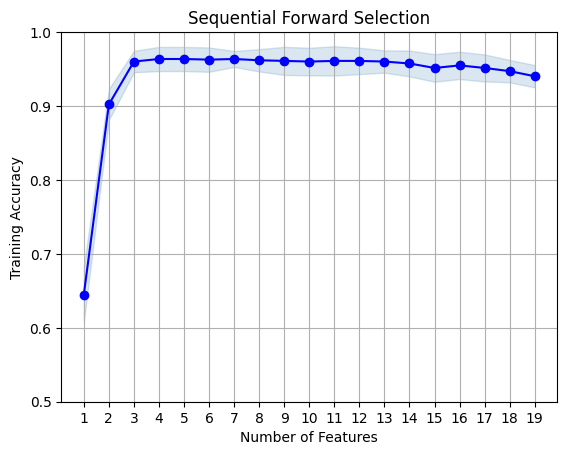

['REGION-CENTROID-ROW', 'REGION-PIXEL-COUNT', 'VEDGE-SD', 'HEDGE-SD', 'RAWRED-MEAN', 'RAWGREEN-MEAN', 'HUE-MEAN']


In [93]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs_forward.get_metric_dict(), 
                ylabel='Training Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection')
plt.grid()
plt.show()
print(sfs_forward_feature_names)

Transform the dataset using the selected subset.

In [94]:
X_train_sfs = sfs_forward.transform(X_train)
X_test_sfs = sfs_forward.transform(X_test)

kNN_sfs = kNN.fit(X_train_sfs,y_train)
y_pred = kNN_sfs.predict(X_test_sfs)
acc_SFS = accuracy_score(y_pred,y_test)
cv_acc_SFS = cross_val_score(kNN, X_train_sfs, y_train, cv=8)

print("X_train shape: ", X_train_sfs.shape)
print("X_Val on SFS all features: {0:.3f}".format(cv_acc_SFS.mean())) 
print("Hold Out testing: {0:2d} features selected using SFS: {1:.3f}".format(len(sfs_forward.k_feature_idx_), acc_SFS)) 

X_train shape:  (1155, 7)
X_Val on SFS all features: 0.961
Hold Out testing:  7 features selected using SFS: 0.948


### Backward Elimination
If we set the SFS `forward` parameter to False it performs Backward Elimination.

In [95]:
verb = 1
sfs_backward = SFS(kNN, 
                  k_features=(1, max_k), 
                  forward=False, 
                  floating=False, 
                  verbose=verb,
                  scoring='accuracy',
                  cv=10, n_jobs = -1)

sfs_backward = sfs_backward.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 18/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 17/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 16/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 15/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 14/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 13/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 12/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 11/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 10/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 9/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
Features: 8/1[Parallel(n_

In [96]:
sfs_backward_feature_names = [X_raw.columns[idx] for idx in sfs_backward.k_feature_idx_]
sfs_backward_feature_names, len(sfs_backward.k_feature_idx_)

(['REGION-CENTROID-ROW',
  'REGION-PIXEL-COUNT',
  'HEDGE-MEAN',
  'INTENSITY-MEAN',
  'RAWRED-MEAN',
  'RAWBLUE-MEAN',
  'RAWGREEN-MEAN',
  'EXRED-MEAN',
  'EXGREEN-MEAN',
  'SATURATION-MEAN'],
 10)

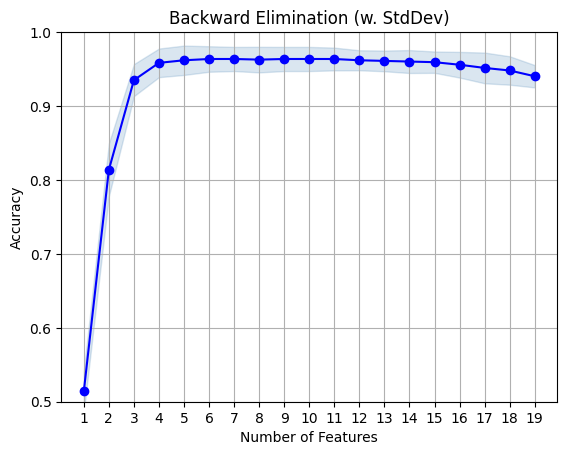

('1', '2', '7', '9', '10', '11', '12', '13', '15', '17')


In [97]:
fig1 = plot_sfs(sfs_backward.get_metric_dict(), 
                ylabel='Accuracy',
                kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Backward Elimination (w. StdDev)')
plt.grid()
plt.show()
print(sfs_backward.k_feature_names_)

In [98]:
X_train_be = sfs_backward.transform(X_train)
X_test_be = sfs_backward.transform(X_test)

kNN_be = kNN.fit(X_train_be,y_train)
y_pred = kNN_be.predict(X_test_be)
acc_BE = accuracy_score(y_pred,y_test)
cv_acc_BE = cross_val_score(kNN, X_train_be, y_train, cv=8)

print("X_train shape: ", X_train_be.shape)
print("X_Val on BE all features: {0:.3f}".format(cv_acc_BE.mean())) 
print("Hold Out testing: {0:2d} features selected using BE: {1:.3f}".format(len(sfs_backward.k_feature_idx_), acc_BE)) 

X_train shape:  (1155, 10)
X_Val on BE all features: 0.960
Hold Out testing: 10 features selected using BE: 0.945


### Plot the overall results

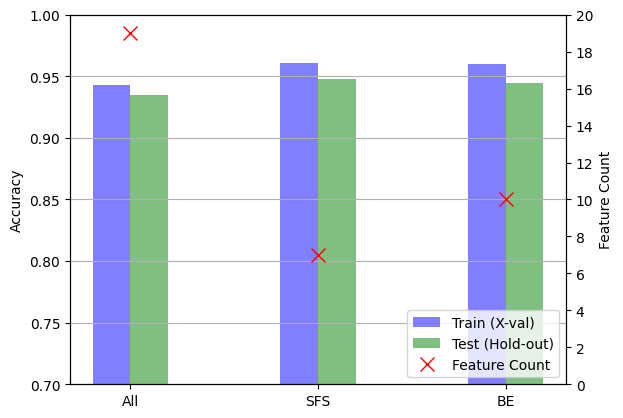

In [99]:
fig, ax = plt.subplots()
width = 0.2

options = ['All', 'SFS', 'BE']
n_feat = [X_train.shape[1], X_train_sfs.shape[1], X_train_be.shape[1]]
accs = [acc,acc_SFS,acc_BE]
xv = [cv_acc.mean(), cv_acc_SFS.mean(), cv_acc_BE.mean()]

y_pos = np.arange(len(options))

p1 = ax.bar(y_pos-width/2, xv, width, align='center', label = 'Train (X-val)',
            color=['blue','blue','blue'],alpha=0.5)
p2 = ax.bar(y_pos+width/2, accs , width, align='center', label = 'Test (Hold-out)',
            color=['g','g','g'],alpha=0.5)

ax.set_ylim([0.7, 1])
ax2 = ax.twinx()

p3 = ax2.plot([0,1,2],n_feat, color = 'red', label = 'Feature Count',
              marker = 'x', ms = 10, linewidth=0)
ax2.set_ylim([0, 20])

ax.grid(axis = 'y')

h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax2.legend(h1+h2, l1+l2, loc='lower right')

ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.xticks(y_pos, options)
ax.set_ylabel('Accuracy')
ax2.set_ylabel('Feature Count')

plt.show()